In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchvision import datasets, transforms
import torch.utils.data
import matplotlib.pyplot as plt

from stochman.geodesic import geodesic_minimizing_energy
from stochman.curves import CubicSpline

from utils import *

# Introduction



### Part i: Geodesics on Data Manifolds

We start with a simple example of how to compute a geodesic between two points and plot  onto a data manifold. We will use a toy dataset and go through the following steps:
1. define a Riemannian metric derived from a kernel density estimate of data
    - This will allow us to develop simple geodesic algorithms
2. represent geodesics using some parametric family of curves
    - We will use 2nd order polynomials and splines for more expressive curves
3. compute the geodesic between two points by minimizing the *energy* of curves

### Part ii: Variational Autoencoders and Geodesics in Latent Space
In the second part, we aim at making identifiable computations in latent space by computing geodesics. We will train a Variational Autoencoder (VAE) on a subset of the MNIST dataset and explore how to move into the latent space using the geodetics as guiding signals.

As before, we first define an energy measure that geodesics should minimize, which is merely the squared error averaged across decoders. The latter step ensures that distances are large in regions of latent space where decoders disagree (regions of high model uncertainty). We use a Monte Carlo estimate of the average across decoders.


## Learning Manifolds from data

We start by learning a manifold from a toy dataset. Let us assume a dataset $X = \{x_1, x_2, \ldots, x_N\}$, where $x_i \in \mathbb{R}^D$ and define the metric as a isotropic scalar function $G(x)=\lambda(x)I$, where $\lambda$ is some positive function. We will use a kernel density estimate to define a Riemannian metric which be used to compute geodesics between points on the manifold.

Guy Lebanon (UAI2003) was the first to propose a method for learning a Riemannian metric from data density. The method, based on a kernel density estimate of the data, defines the metric as the inverse of the density estimate. We denote $p(x)$  the density estimated from the data, the proposal was to define the metric $G$ such that geodesics are attracted to regions of high density, $\sqrt{\det{G(x)}}^{-1} \propto p(x)$ . With the previous metric definition, we can rewrite the left part of the latter as $\sqrt{\det{\lambda(x)I}}^{-1}=\sqrt{\lambda(x)^D}^{-1}=\lambda(x)^{-\frac{D}{2}}$. A simple python implementation of the metric is shown below.

In [3]:
class DensityMetric(nn.Module):
    def __init__(self, data, sigma):
        super(DensityMetric, self).__init__()
        self.data = data
        self.sigma = sigma

    def density(self, x):
        """
        Evaluate a kernel density estimate at x.

        Parameters:
            x: points where the density is evaluated. Dimensions (num_points)x(data_dim)
        """
        N, D = x.shape
        M, _ = self.data.shape
        sigma2 = self.sigma**2
        normalization = (2 * 3.14159)**(D/2) * self.sigma**D  # scalar
        distances = torch.cdist(x, self.data)  # NxM
        K = torch.exp(-0.5 * distances**2 / sigma2) / normalization  # NxM
        p = torch.sum(K, dim=1)  # N
        return p

    def curve_energy(self, C):
        """
        Compute the length of a curve

        Parameters:
        C: points along a curve. Dimensions (batch)x(num_points_along_curve)x(data_dim)
        """
        if C.dim() == 2:
            C = C.unsqueeze(0)
        B, lenT, D = C.shape
        CC = C.reshape(-1, D)
        p = self.density(CC)  # (B*lenT)
        metric = 1 / (p + 1e-4).reshape(B, lenT)  # (B)x(lenT)
        avg_metric = 0.5 * metric[:, 1:] + 0.5 * metric[:, :-1]  # (B)x(lenT-1)
        delta = C[:, 1:] - C[:, :-1]  # (B)x(lenT-1)x(D)
        energy = torch.sum(torch.sum(delta**2, dim=2) * avg_metric, dim=1)  # (B)
        return energy

Although it only requires access to unnormalized densities, the main drawback is that that metric scales poorly with dimensionality. That means that computing geodesics in high-dimensional spaces is computationally expensive. Thus, a simple solution to this issue is to reduce the dimensionality of the data by using methods such as Latent variable Models, namely Variational AutoEncoders. Nevertheless, this approach is useful to understand the concept of geodesics and how to compute them.

#### Loading the data

In [4]:
toydata = np.load('data/toybanana.npy')
data = torch.from_numpy(toydata).to(dtype=torch.float32)  # 992x2
num_curves = 30
N, D = data.shape
curve_indices = torch.randint(data.shape[0], (num_curves, 2))  # (num_curves) x 2
#plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
#plt.show()

Once we load the data, we can define the density metric. We will use a Gaussian kernel with bandwidth $\sigma=0.1$.

In [5]:
dm = DensityMetric(data, 0.1)
dm_energy = lambda model, curve: dm.curve_energy(curve.points())

Embedded with the density-based metric, we can now compute the geodesics on the manifold. But first we need to define a parametric family of curves that we will use to represent geodesics. For simplicity, we here just consider 2nd order polynomials (class ```Poly2``` in ```utils.py```) and later we will use splines (from the ```stochman``` library) as more expressive curves. The following code snippet shows how to compute the geodesic between two points and plot it onto the data manifold.

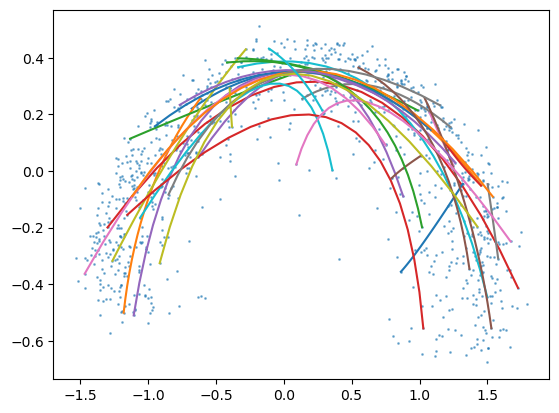

In [6]:
## Plot data and random geodesics
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
for k in tqdm(range(num_curves), leave=False):
    c = Poly2(data[curve_indices[k, 0]], data[curve_indices[k, 1]], 20)
    connecting_geodesic(dm, c, energy_fun = dm_energy, max_iter = 200)
    c.plot('-')
plt.show()

For the sake of the example, we will adapt the class ```CubicSpline``` from the ```stochman``` library so to make it adhere with the interface of the DensityMetric and dm_energy.

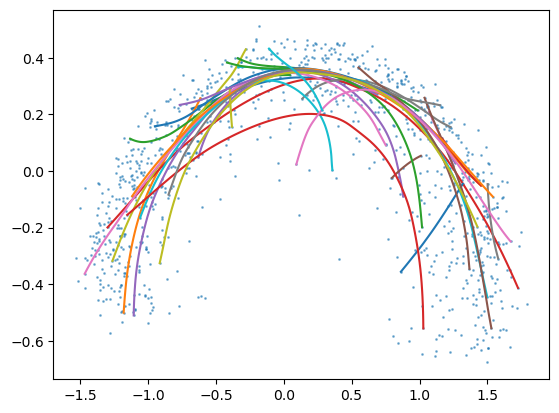

In [8]:
## Plot data and random geodesics
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
for k in tqdm(range(num_curves), leave=False):
    c = Spline(begin=data[curve_indices[k, 0]], end=data[curve_indices[k, 1]], num_nodes=20)
    connecting_geodesic(dm, c, energy_fun = dm_energy, max_iter = 200)
    c.plot()
plt.show()

Here we show an example of using the ```stochman``` library to go way faster thanks to the parallel computation provided by the very library.


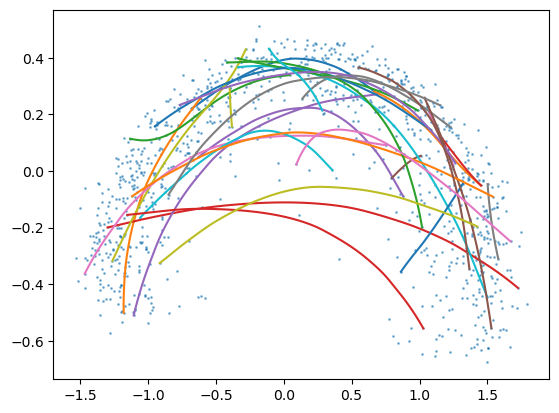

In [15]:
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
batch_c = CubicSpline(begin=data[curve_indices[:, 0]], end=data[curve_indices[:, 1]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=dm, max_iter = 200)
batch_c.plot()
plt.show()

In [11]:
batch_c.points().shape

torch.Size([30, 20, 2])

Here we create the object for evaluating the energy of the curve, which make finite difference approximations to the curve derivative.

In [5]:
# Parameters for metric
sigma = 0.1
rho = 0.1
import stochman
# Create metric
M = stochman.manifold.LocalVarMetric(data=data, sigma=sigma, rho=rho)

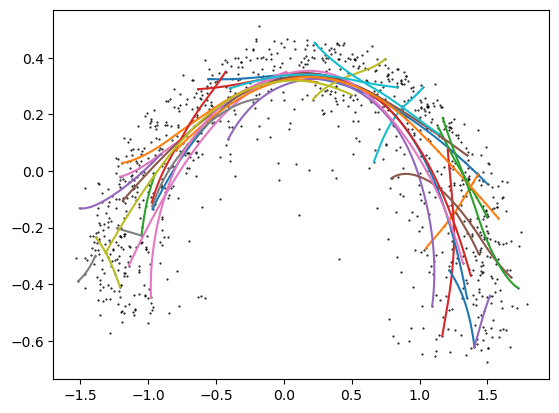

In [6]:
p0 = data[torch.randint(high=N, size=[num_curves], dtype=torch.long)]  # 10xD
p1 = data[torch.randint(high=N, size=[num_curves], dtype=torch.long)]  # 10xD
C, success = M.connecting_geodesic(p0, p1)
plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), "k.", markersize=1)
C.plot()
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]


AttributeError: 'CubicSpline' object has no attribute 'dim'

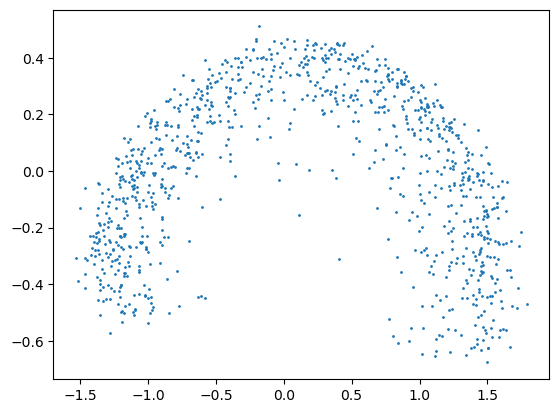

In [9]:
## Plot random geodesics
plt.scatter(data[:, 0], data[:, 1], s=1)
with tqdm(range(num_curves)) as pbar:
    for k in pbar:
        i = curve_indices[k, 0]
        j = curve_indices[k, 1]
        curve = CubicSpline(data[i], data[j], 20)
        M.curve_energy(curve)
        #connecting_geodesic(dm, c, energy_fun = dm_energy, max_iter = 200)
        curve.plot('-')

## Loading the data

We start by loading the data. We will use a subset of the MNIST dataset, containing only the digits 0, 1, and 2.


In [6]:
def subsample(data, targets, num_data, num_classes):
    idx = targets < num_classes
    new_data = data[idx][:num_data].unsqueeze(1).to(torch.float32) / 255
    new_targets = targets[idx][:num_data]

    return torch.utils.data.TensorDataset(new_data, new_targets)

num_train_data = 2048
num_classes = 3
train_tensors = datasets.MNIST('data/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_data = subsample(train_tensors.data, train_tensors.targets, num_train_data, num_classes)
mnist_train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)

In [4]:
torch.manual_seed(314159)
M = 2  # latent dimension is two for plotting
prior = GaussianPrior(M)

encoder_net = nn.Sequential(
    nn.Conv2d(1, 16, 3, stride=2, padding=1),
    nn.Softplus(),
    nn.Conv2d(16, 32, 3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(1568, 2*M),
)

def new_decoder():
    decoder_net = nn.Sequential(
        nn.Linear(M, 512),
        nn.Unflatten(-1, (32, 4, 4)),
        nn.Softplus(),
        nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=0),
        nn.Softplus(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.Softplus(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
    )
    return decoder_net

# Define ensemble of VAE models
num_ensembles = 10
models, optimizers = [], []
encoder = GaussianEncoder(encoder_net)
for _ in range(num_ensembles):
    decoder = BernoulliDecoder(new_decoder())
    model = VAE(prior, decoder, encoder)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    models.append(model)
    optimizers.append(optimizer)

In [5]:
# Run the training loop
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train(models, optimizers, mnist_train_loader, epochs, device)

epoch=99, step=6395, loss=-1248.8: 100%|██████████| 6400/6400 [00:46<00:00, 137.49it/s]


# Now comes the geometry part
So far we have trained a VAE to fit the data. Now we start making identifiable computations in latent space by computing geodesics.

We first define an energy measure that geodesics should minimize. This is merely the squared error, which is averaged across decoders. The latter step ensures that distances are large in regions of latent space where decoders disagree (regions of high model uncertainty). We use a Monte Carlo estimate of the average across decoders.

In [6]:
def ensemble_energy(models, curve):
    num_models = len(models)
    C = curve.points()  # M x (latent_dim)
    M = C.shape[0]
    P = [model.decoder(C).mean.reshape(1, M, -1) for model in models]
    P = torch.concatenate(P, dim=0)  # (num_models) x M x 28²

    rp0 = torch.randperm(num_models)  # (num_models)
    rp1 = torch.randperm(num_models)  # (num_models)

    #p0 = td.Bernoulli(probs = P[rp0, 1:, :])  # (num_models) x (M-1) x 28²
    #p1 = td.Bernoulli(probs = P[rp1, :-1, :])  # (num_models) x (M-1) x 28²
    #E = KL(p0, p1)  # (num_models) x (M-1) x 28²
    E = (P[rp0, 1:, :] - P[rp1, :-1, :])**2
    return E.mean()

In [13]:
## Put trained models in 'eval' mode
for m in range(num_ensembles):
    models[m].eval()

## Encode training data
latents, labels = [], []
with torch.no_grad():
    for x, y in mnist_train_loader:
        x = x.to(device)
        z = models[0].encoder(x)
        latents.append(z.mean)
        labels.append(y)
    latents = torch.concatenate(latents, dim=0)
    labels = torch.concatenate(labels, dim=0)

100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


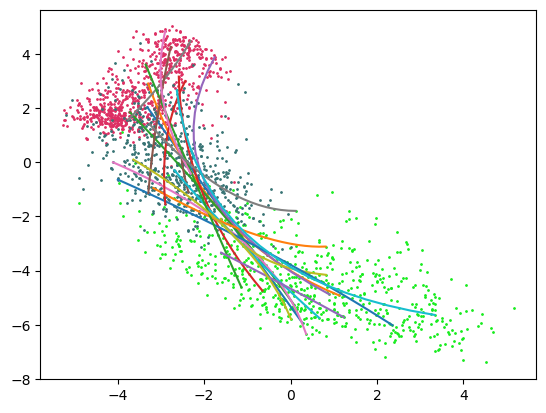

In [17]:
## Plot training data
for k in range(num_classes):
    col = torch.rand(3).numpy()
    idx = labels == k
    plt.scatter(latents[idx, 0].cpu(), latents[idx, 1].cpu(), s=1, color=col)
# Plot random geodesics
num_curves = 20
dm = DensityMetric(latents, 0.5)
dm_energy = lambda model, curve: model.curve_energy(curve.points())
curve_indices = torch.randint(num_train_data, (num_curves, 2))  # (num_curves) x 2
with tqdm(range(num_curves)) as pbar:
    for k in pbar:
        i = curve_indices[k, 0]
        j = curve_indices[k, 1]
        c = Poly2(latents[i], latents[j], 20, device=device)
        connecting_geodesic(dm, c, energy_fun = dm_energy, max_iter = 100)  # initialization
        energy = connecting_geodesic(models, c, energy_fun = ensemble_energy, max_iter = 10, lr = 0.01)  # smaller learning rate as the energy i stochastic
        c.plot('-')

### Pull-back Metric

Let us assume a trained VAE, expressed by $\hat{x}=d_\theta(e_\theta(x))$ where $e_\theta$ and $d_\theta$ are the encoder and decoder functions of the model. We can define a pull-back metric Riemannian metric $G$ on the latent space as $G(z) = J_{_\theta}(z)^TJ_{_\theta}(z)$, where $J(x)$ is the Jacobian of the decoder at $z$.

By construction, computations according to this metric are invariant to reparameterization of the latent space.

In [62]:
from core import utils
# Construct an artificial dataset
params = {'N': 2000, 'data_type': 2, 'r': .2, 'sigma': 0.1}
X_train = utils.generate_data(params)
N_train, D = X_train.shape
D

3

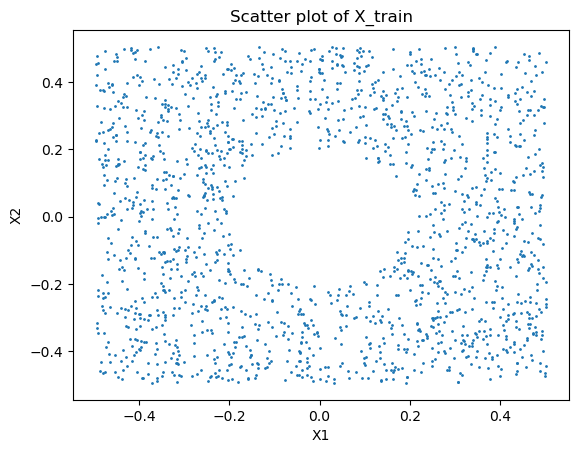

In [63]:
# Assuming X_train is a numpy array
plt.scatter(X_train[:, 0], X_train[:, 1], s=1)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter plot of X_train')
plt.show()

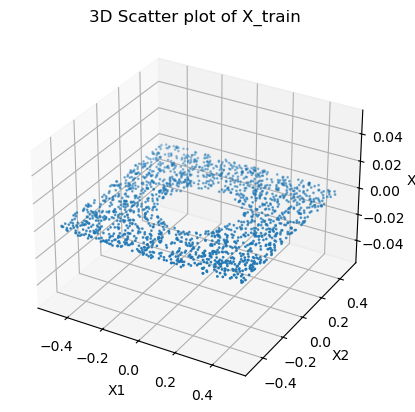

In [65]:
# Plot X_train
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_train is a numpy array with at least 3 columns
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], 0, s=1)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('3D Scatter plot of X_train')

plt.show()